In [1]:
from context import lens
from lens.sis.inference import *

In [2]:
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import emcee

note the clipboard should have been set with the correct data

In [3]:
s = pd.read_clipboard()

In [4]:
s

,qso_name,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,test,mu,mu_error,mu_norm,x,y
0,SBS0909+523,1.635721e+18,b'Gaia DR2 1022663637669586176',1.022664e+18,1.533164e+09,2015.5,138.254177,0.155021,52.991387,0.213628,...,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,40.260320,3.417354,0.496323,6.885343,-0.819619,0.248677
1,SBS0909+523,1.635721e+18,b'Gaia DR2 1022663637670776192',1.022664e+18,1.373021e+09,2015.5,138.254632,0.075504,52.991248,0.135302,...,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,62.536185,0.788551,0.305305,2.582828,0.819619,-0.248677


In [5]:
s.source_id

0    1.022664e+18
1    1.022664e+18
Name: source_id, dtype: float64

In [6]:
s['phot_g_mean_mag']

0    16.416710
1    17.013699
Name: phot_g_mean_mag, dtype: float64

In [7]:
s.phot_g_mean_mag-2.5*np.log(s.phot_g_mean_flux)

0   -4.932068
1   -2.960460
dtype: float64

In [8]:
s.phot_g_mean_mag/s.phot_g_mean_flux_over_error

0    0.098849
1    0.101175
dtype: float64

Since Gaia does not provide g mag error, I use quick approximation using the flux error... better to adapt the SIS code to use flux instead of magnitude.

In [9]:
s['x']=(s.ra-s.ra.mean())*u.deg.to(u.arcsec)
s['y']=(s.dec-s.dec.mean())*u.deg.to(u.arcsec)
s['dx']=(s.pmra-s.pmra.mean())
s['dy']=(s.pmdec-s.pmdec.mean())
s['xe']=s.ra_error*u.mas.to(u.arcsec)
s['ye']=s.dec_error*u.mas.to(u.arcsec)
s['dxe']=s.pmra_error
s['dye']=s.pmdec_error
s['g'] = s.phot_g_mean_mag
s['ge'] = s.phot_g_mean_mag/s.phot_g_mean_flux_over_error

In [10]:
def plot_chains(sampler,warmup=400):
    fig, ax = plt.subplots(ndim,3, figsize=(12, 12))
    samples = sampler.chain[:, warmup:, :].reshape((-1, ndim))
    medians = []
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i,0].vlines(warmup,np.min(sampler.chain[:, :, i].T),np.max(sampler.chain[:, :, i].T),'r')
        ax[i,1].hist(samples[:,i],bins=100,label=parameter[i]);
        ax[i,1].legend()
        ax[i,1].vlines(np.median(samples[:,i]),0,10000,lw=1,color='r',label="median")
        medians.append(np.median(samples[:,i]))
        ax[i,2].hexbin(samples[:,i],samples[:,(i+1)%ndim])#,s=1,alpha=0.1);
    return medians

# SIS lens inference

In [11]:
parameter = "xS,yS,gS,bL,xL,yL".split(',')

In [12]:
data = s[['x','y','g','xe','ye','ge']].as_matrix()

In [13]:
data

array([[-8.19618877e-01,  2.48677000e-01,  1.64167100e+01,
         1.55020570e-04,  2.13627752e-04,  9.88487652e-02],
       [ 8.19618877e-01, -2.48677000e-01,  1.70136990e+01,
         7.55039085e-05,  1.35302460e-04,  1.01174619e-01]])

In [14]:
np.random.seed(0)
def init(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(0,0.2,size=N)
    yS = norm.rvs(0,0.2,size=N)
    gS = gamma.rvs(10,5,size=N)
    xL = norm.rvs(0,0.2,size=N)
    yL = norm.rvs(0,0.2,size=N)
    bL = beta.rvs(2,3,size=N)
    return np.transpose(np.array([xS,yS,gS,bL,xL,yL]))

In [15]:
ndim = 6  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps

In [16]:
starting_guesses = init(nwalkers)

In [17]:
np.std([log_prior(guess) for guess in starting_guesses])

2.4913524849163284

In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

/Users/abombrun/Documents/GitHub/GaiaLQSO/lens/sis/inference.py:31: RuntimeWarning: divide by zero encountered in log10
  res = res + np.log10(radiusPrior(bL))
/Users/abombrun/Documents/GitHub/GaiaLQSO/lens/sis/inference.py:29: RuntimeWarning: divide by zero encountered in log10
  res = np.log10(positionPrior(xS)) + np.log10(positionPrior(yS)) + np.log10(magnitudePrior(gS))


CPU times: user 54.7 s, sys: 309 ms, total: 55 s
Wall time: 55 s


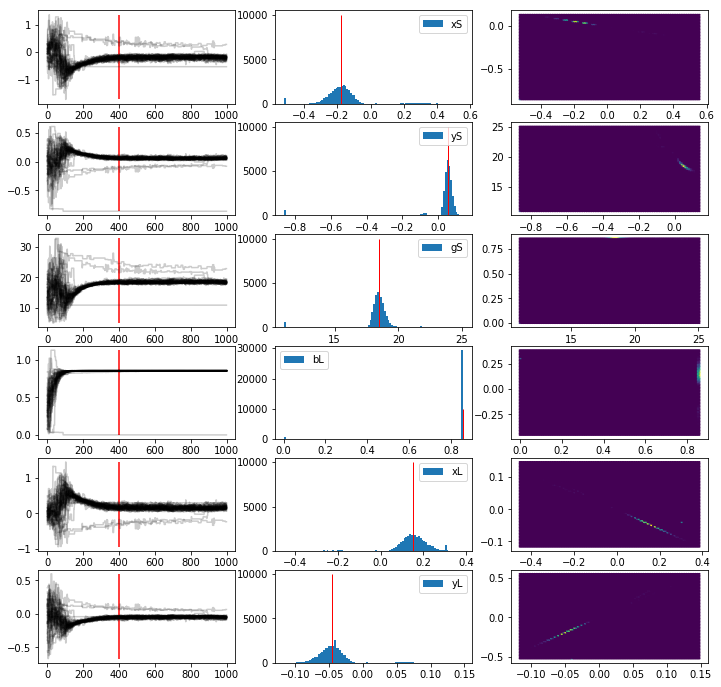

In [19]:
medians = plot_chains(sampler)

In [20]:
medians

[-0.17949645883221227,
 0.05356919960672257,
 18.50715782572496,
 0.8565007096565008,
 0.15376463970175144,
 -0.04588487306260381]

In [21]:
np.random.seed(0)
def init2(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(medians[0],0.02,size=N)
    yS = norm.rvs(medians[1],0.02,size=N)
    gS = norm.rvs(medians[2],1,size=N)
    bL = norm.rvs(medians[3],0.1,size=N)
    xL = norm.rvs(medians[4],0.02,size=N)
    yL = norm.rvs(medians[5],0.01,size=N)
    
    return np.transpose(np.array([xS,yS,gS,bL,xL,yL]))

In [22]:
starting_guesses2 = init2(nwalkers)

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses2, nsteps)

CPU times: user 54.6 s, sys: 239 ms, total: 54.8 s
Wall time: 54.8 s


[-0.1889880427739348,
 0.05734069037295818,
 18.454188224894082,
 0.8565144467847229,
 0.1618493230569677,
 -0.049116424472037276]

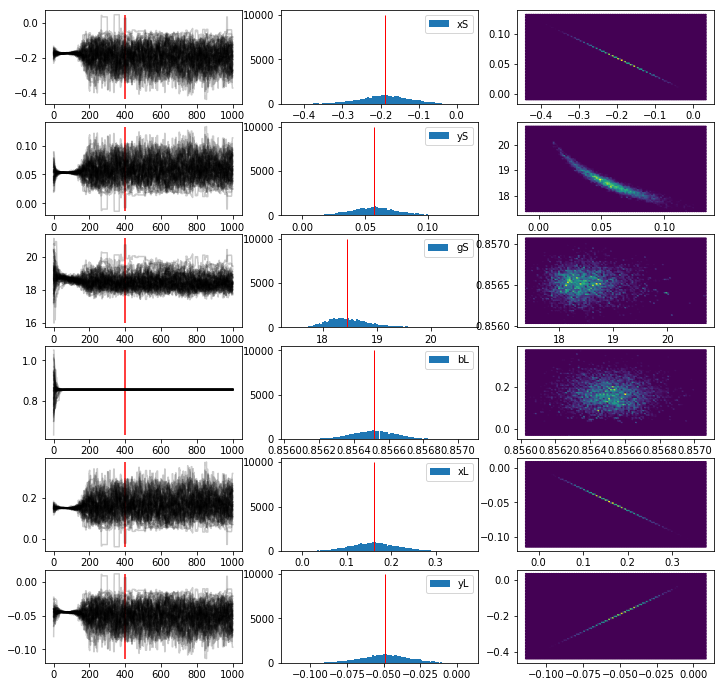

In [24]:
plot_chains(sampler)

# Proper motion inference

In [25]:
parameter = "xS,yS,dxS,dyS,gS,bL,xL,yL".split(',')

In [26]:
from lens.sis.inferencePM import *

In [27]:
data_pm = s[['x','y','dx','dy','g','xe','ye','dxe','dye','ge']].as_matrix()

In [28]:
data_pm

array([[-8.19618877e-01,  2.48677000e-01,  6.69251998e-02,
        -2.09383176e+00,  1.64167100e+01,  1.55020570e-04,
         2.13627752e-04,  2.91124546e-01,  4.65920820e-01,
         9.88487652e-02],
       [ 8.19618877e-01, -2.48677000e-01, -6.69251998e-02,
         2.09383176e+00,  1.70136990e+01,  7.55039085e-05,
         1.35302460e-04,  1.47239152e-01,  2.49159343e-01,
         1.01174619e-01]])

In [29]:
np.random.seed(0)
def initPM(N):
    """ to initialise each walkers initial value : sets parameter randomly """
    xS = norm.rvs(medians[0],0.02,size=N)
    yS = norm.rvs(medians[1],0.02,size=N)
    gS = norm.rvs(medians[2],1,size=N)
    bL = norm.rvs(medians[3],0.1,size=N)
    xL = norm.rvs(medians[4],0.02,size=N)
    yL = norm.rvs(medians[5],0.01,size=N)
    
    dxS = norm.rvs(0,0.1,size=N)
    dyS = norm.rvs(0,0.1,size=N)
    
    return np.transpose(np.array([xS,yS,dxS,dyS,gS,bL,xL,yL]))

In [30]:
ndim = 8  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 2000  # number of MCMC steps

In [31]:
starting_guesses_pm = initPM(nwalkers)

In [32]:
np.std([log_prior_pm(guess) for guess in starting_guesses_pm])

0.25496963864248917

In [33]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_pm, args=[data_pm])
%time x = sampler.run_mcmc(starting_guesses_pm, nsteps)

CPU times: user 2min 18s, sys: 752 ms, total: 2min 18s
Wall time: 2min 18s


In [36]:
s.qso_name[0]

'SBS0909+523'

In [38]:
mkdir ../data/images

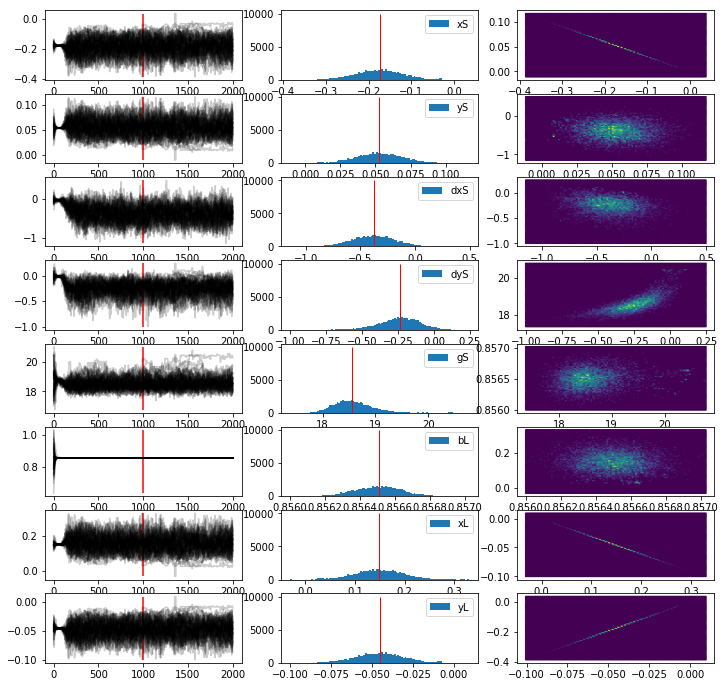

In [39]:
medians = plot_chains(sampler,warmup=1000)
plt.savefig("../data/images/PMI_%s.png"%s.qso_name[0])

In [40]:
medians

[-0.17373156972020198,
 0.0526938723880006,
 -0.37890676490489855,
 -0.23415318934699159,
 18.556475335147372,
 0.85650738797334,
 0.14877893179318677,
 -0.04516597769665398]